**Warmup**

一开始网络还不稳定（权重随机、BN 统计未就绪、动量未热身），直接用大 LR 容易发散；warmup 先用小 LR 起步再平滑升到目标 LR。

常见做法（$t$ 为第 t 步，$T_w$ 为 warmup 步数；$\eta_{\max}$ 为峰值 LR）：
- Constant Warmup（常数热身）
    - 前 $T_w$ 步用常数小 LR（如 $0.1\eta_{\max}$），之后切到主调度；
    - 简单稳妥，适合对抖动敏感的任务；
- Linear Warmup（线性热身，最常用）
    - $\eta(t) = \eta_{\max}\cdot \frac{t}{T_w}\quad (t\le T_w)$
    - 线性爬坡到 $\eta_{\max}$，之后接主调度（余弦 / 多项式 / 恒定等）；
- Exponential Warmup（指数热身）
    - $\eta(t) = \eta_{\max}\cdot \exp\!\big((t/T_w-1)\cdot \log r\big)$；
    - 早期更温和，适合极不稳定开局；
- Cosine Warmup（余弦热身）
    - $\eta(t) = \eta_{\max}\cdot \frac{1-\cos\!\big(\pi\cdot t/T_w\big)}{2}$；
	- 与后续的余弦退火风格一致，整体更平滑；
- Warmup + Inverse-Sqrt Decay（Transformer 常见）
    $$
    \eta(t)=\eta_{\max}\cdot
    \begin{cases}
    \frac{t}{T_w}, & t \le T_w\\[2pt]
    \frac{\sqrt{T_w}}{\sqrt{t}}, & t>T_w
    \end{cases}
    $$
    - 早期线性升，后期 $1/\sqrt{t}$ 衰减；
    - 适合序列建模、自注意力；
- One-Cycle（单周期策略）
    - 先热身到最大 LR，再用余弦降到很小的 LR；常配合反向动量曲线；
    - 适合需要在固定步数里迅速到点的场景（如分类预训练）；

如下是 Linear Warmup → Cosine Decay 的主流组合。

In [2]:
import torch

model = torch.nn.Linear(10, 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

total_steps = 10000
warmup_steps = 800

warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1e-3, end_factor=1.0, total_iters=warmup_steps
)
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=total_steps - warmup_steps, eta_min=1e-4
)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[warmup, cosine], milestones=[warmup_steps]
)

for step in range(total_steps):
    # ... forward/backward ...
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

Warmup + Inverse-Sqrt（Transformer 风格）的实现。

In [3]:
import torch

model = torch.nn.Linear(10, 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

total_steps  = 10000
warmup_steps = 4000

def lr_lambda(step):
    if step == 0:
        return 1e-8  # avoid 0
    if step <= warmup_steps:
        return step / warmup_steps
    else:
        return (warmup_steps ** 0.5) / (step ** 0.5)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

for step in range(total_steps):
    # ... forward/backward ...
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

One-Cycle 带 warmup 的单周期。

In [7]:
import torch

model = torch.nn.Linear(10, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

total_steps = 30000
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.4,                # peak LR after warmup
    total_steps=total_steps,
    pct_start=0.1,             # first 10% steps for warmup
    anneal_strategy='cos',
    div_factor=25,             # initial LR = max_lr/div_factor
    final_div_factor=1e4       # final LR = max_lr/final_div_factor
)
scheduler.base_lrs

[0.016]

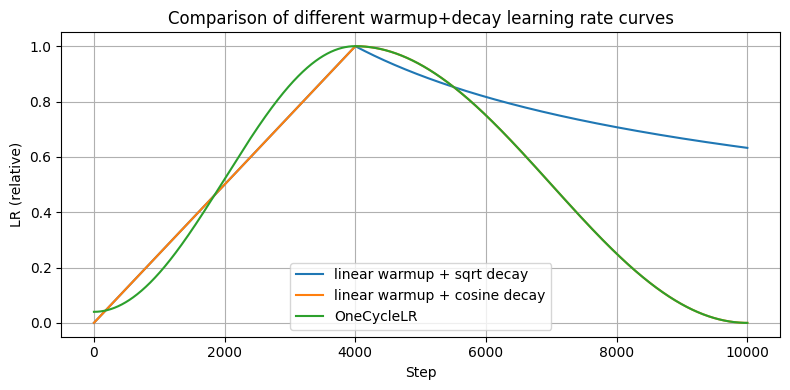

In [10]:
import numpy as np
import matplotlib.pyplot as plt

total_steps = 10000
warmup_steps = 4000

steps = np.arange(1, total_steps + 1)

# 1. linear warmup + sqrt decay
def lr_lambda_sqrt(step):
    if step <= warmup_steps:
        return step / warmup_steps
    else:
        return (warmup_steps ** 0.5) / (step ** 0.5)
lrs_sqrt = [lr_lambda_sqrt(s) for s in steps]

# 2. linear warmup + cosine decay
def lr_lambda_cos(step):
    if step <= warmup_steps:
        return step / warmup_steps
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + np.cos(np.pi * progress))
lrs_cos = [lr_lambda_cos(s) for s in steps]

# 3. OneCycleLR
from torch.optim.lr_scheduler import OneCycleLR
import torch

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
onecycle = OneCycleLR(
    optimizer,
    max_lr=1.0,
    total_steps=total_steps,
    pct_start=warmup_steps/total_steps,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)
lrs_onecycle = []
for _ in range(total_steps):
    lrs_onecycle.append(onecycle.get_last_lr()[0])
    onecycle.step()

plt.figure(figsize=(8, 4))
plt.plot(steps, lrs_sqrt, label='linear warmup + sqrt decay')
plt.plot(steps, lrs_cos, label='linear warmup + cosine decay')
plt.plot(steps, lrs_onecycle, label='OneCycleLR')
plt.xlabel('Step')
plt.ylabel('LR (relative)')
plt.title('Comparison of different warmup+decay learning rate curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**LR ∝ B 线性缩放**

- 一个 epoch 有 N/B 个 step；若把 batch 改成 kB，每个 epoch 的步数变成 N/(kB)，少了 k 倍；
- 若把 LR 同时放大到 $k\eta$，那么每个 epoch 的累计更新量大致不变 $(N/(kB))\cdot k\eta \approx (N/B)\cdot \eta$；
- 把 batch 放大 k 倍，就把 LR 也放大 k 倍，能维持接近的训练动力学（再配合 warmup 保证稳定）；

或者说
- 小批量梯度 $\hat g=\frac{1}{B}\sum_{i=1}^B g_i$ 的方差 $\text{Var}(\hat g)\propto 1/B$，batch 越大，噪声越小；
- 当噪声减小时，可以承受更大的步长（LR）而不发散；线性缩放在很多视觉 / NLP大规模训练里被验证有效；

但也不是无限线性，如果超过某个临界 batch，收益会变弱或泛化变差；这时候考虑增 warmup 步数、配 LARS / LAMB 等大 batch 友好优化器。

**LARS（Layer-wise Adaptive Rate Scaling）**

核心想法：对每一层算一个信任比率（trust ratio）
$$
\text{trust\_ratio}_\ell
\;=\;
\eta \cdot \frac{\lVert w_\ell\rVert}{\lVert g_\ell \rVert + \epsilon}
$$


用它去缩放全局学习率

$$\text{lr}_\ell = \text{lr} \times \text{trust\_ratio}_\ell$$

再做 SGD (+momentum) 更新。

- 让每层的相对更新幅度 $\lVert \Delta w_\ell\rVert/\lVert w_\ell\rVert$ 更一致，避免层间尺度差异在巨型 batch 下被放大导致训练不稳；
- 常见用法是超大 batch 训练 CNN（如 ImageNet 32K + batch）；
- 通常跳过 BN / 偏置层的层级自适应与权重衰减（trust ratio 置 1 即可）；

**LAMB（Layer-wise Adaptive Moments for Batch training）**

核心想法：先像 Adam / AdamW 一样算自适应步子（按二阶动量归一化），再加一层 layer-wise trust ratio；
$$
u_\ell=\frac{\hat m_\ell}{\sqrt{\hat v_\ell}+\epsilon} \quad(\text{Adam 方向})
\qquad
r_\ell=\frac{\lVert w_\ell\rVert}{\lVert u_\ell \rVert+\epsilon}
\qquad
\Delta w_\ell=-\text{lr}\cdot r_\ell\cdot u_\ell
$$

In [8]:
import torch
from torch.optim.optimizer import Optimizer

def _exclude(p_name):
    # If the name contains 'bn', 'ln', 'bias', do not adapt to layer-wise
    n = p_name.lower()
    return ("bn" in n) or ("ln" in n) or ("bias" in n)

class LARS(Optimizer):
    def __init__(self, params, lr=0.1, momentum=0.9, weight_decay=1e-4,
                 eta=0.001, eps=1e-9, trust_clip=None):

        # support (name, param)
        named = []
        raw = []
        for p in params:
            if isinstance(p, tuple):
                named.append(p)
            else:
                raw.append(p)

        if named:
            param_groups = [{"params":[p for _, p in named], "names":[n for n, _ in named]}]
        else:
            param_groups = [{"params": raw, "names": ["" for _ in raw]}]

        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay,
                        eta=eta, eps=eps, trust_clip=trust_clip)
        super().__init__(param_groups, defaults)

        # allocate state for each param
        for group in self.param_groups:
            for p in group["params"]:
                self.state[p]["momentum_buffer"] = torch.zeros_like(p, memory_format=torch.preserve_format)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None if closure is None else closure()

        for group in self.param_groups:
            lr = group["lr"]
            mom = group["momentum"]
            wd  = group["weight_decay"]
            eta = group["eta"]
            eps = group["eps"]
            clip= group["trust_clip"]
            names = group.get("names", [""]*len(group["params"]))

            for name, p in zip(names, group["params"]):
                if p.grad is None:
                    continue

                g = p.grad

                # decoupled weight decay
                if wd != 0 and not _exclude(name):
                    p.add_(p, alpha=-lr*wd)

                # momentum
                buf = self.state[p]["momentum_buffer"]
                buf.mul_(mom).add_(g)

                # layer-wise trust ratio (not adapt to BN/LN/bias)
                if _exclude(name):
                    trust_ratio = 1.0
                else:
                    w_norm = p.norm()
                    u_norm = buf.norm()
                    if w_norm > 0 and u_norm > 0:
                        trust_ratio = eta * (w_norm / (u_norm + eps))
                        if clip is not None:
                            trust_ratio = min(trust_ratio, clip)
                    else:
                        trust_ratio = 1.0

                # update
                p.add_(buf, alpha=-lr * trust_ratio)

        return loss